In [2]:
import sys
import os

sys.path.append('/home/davcic/CP_Testing')

# args = 5
# os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
# print(f'Selected GPU {args}')
os.environ['CUDA_VISIBLE_DEVICES'] = ''


import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import jaxkern as jk

import matplotlib.colors as cm

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

2024-05-07 16:29:35.781207: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [24]:
num_mcmc_steps = 100
name = f"_{num_mcmc_steps}_lga_passengers_combined"
particles = jnp.load("particles" + name + ".npy", allow_pickle = True)[()]
f_pred = jnp.load("f_pred" + name + ".npy")
y_pred = jnp.load("y_pred" + name + ".npy")

468


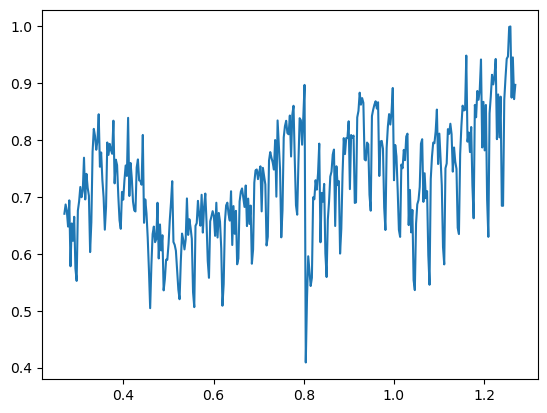

In [26]:
from load_dataset import TimeSeries
readname = 'lga_passengers'
savename = 'lga_passengers'
data = TimeSeries.from_json(f'datasets/{readname}/{readname}.json')
# fig = plt.figure(figsize = (10, 6))
# y_data = data.y[15:]
print(len(data.y))
# x_data = data.t[15:]-15
corr_data = data.y[99:]/jnp.max(data.y[99:])
plt.plot(data.t[99:]/(len(data.t[99:])-1), corr_data)

TypeError: list indices must be integers or slices, not str

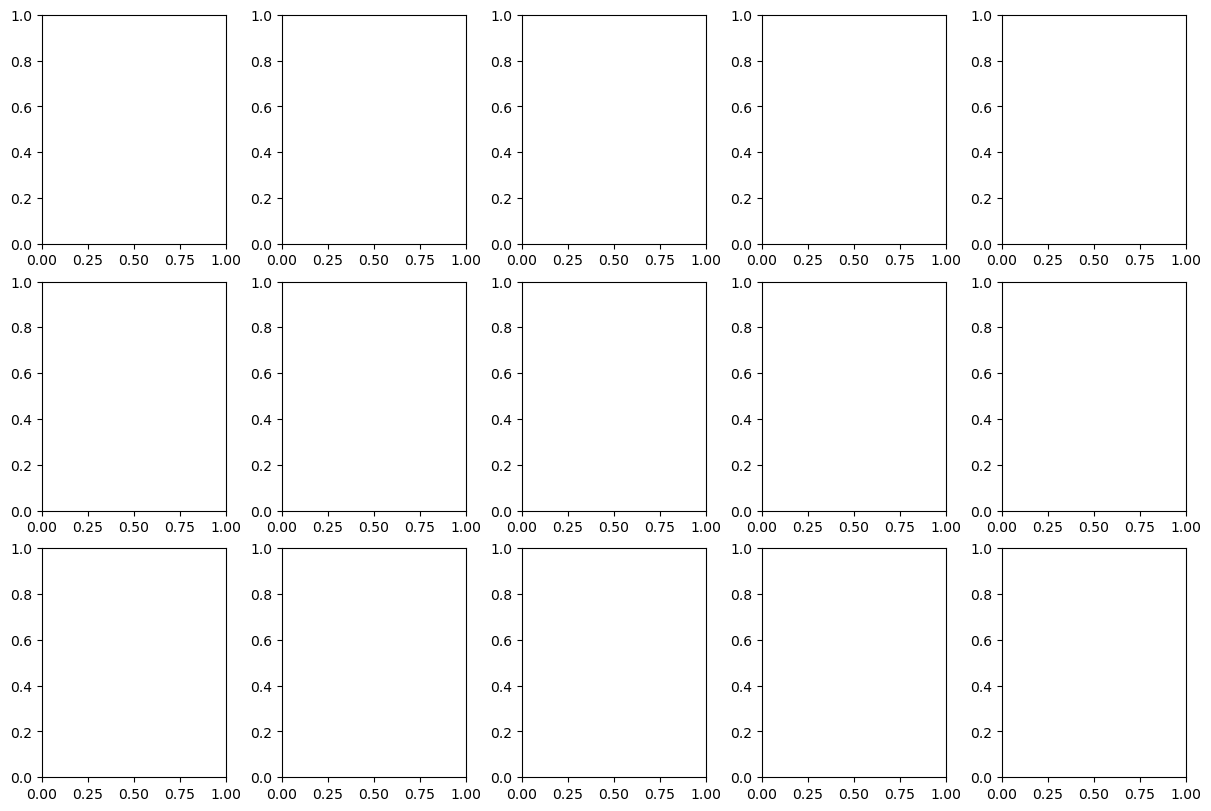

In [4]:
x_pred = jnp.linspace(-0, 1, num=100)

trainables = ['lengthscale', 'variance', 'period']

num_params = len(trainables)

symbols = dict(lengthscale='\ell',
            variance=r'\tau')
num_CP = 4
_, axes = plt.subplots(nrows=num_params, ncols=num_CP+1, constrained_layout=True,
                    figsize=(12, 8))


# particles = lgp_particles
tr = dict(lengthscale=particles['kernel']['lengthscale'],
            variance=particles['kernel']['variance'],
            period = particles['kernel']['period']
            )
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    # pd_filtered = jnp.extract(pd>pd_l, pd)
    # pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(num_CP+1):
      axes[j, i].hist(pd[:, i][~jnp.isnan(pd[:, i])], bins=30, density=True, color='tab:blue')
    #   axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')
axes[1, 0].set_ylabel('period', rotation=0, ha='right')

plt.savefig(f"{savename}/{savename}_posteriors_periodic")

TypeError: list indices must be integers or slices, not str

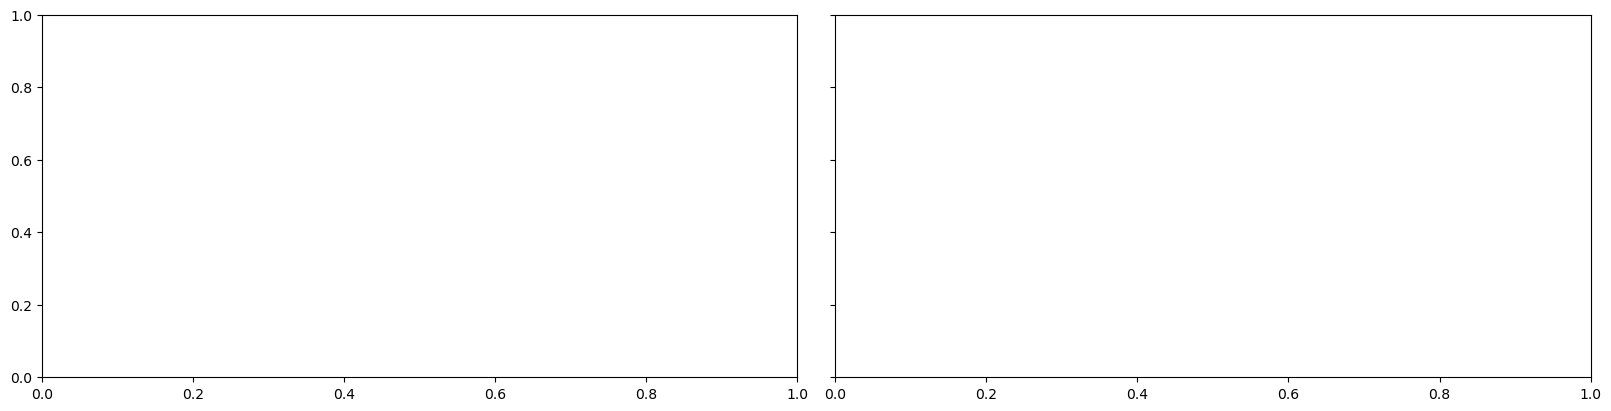

In [5]:
x_pred = jnp.linspace(0, 1, num=y_pred.shape[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


# key, key_pred = jrnd.split(key)
# f_pred = gp_latent.predict_f(key_pred, x_pred)

pd = particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)


ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.nanmean(f_pred, axis=0)
# y_pred = gp_latent.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

x = x_pred
for ax in axes.flatten():
    # ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, corr_data, 'rx', label='obs')
    # ax.set_xlim([-0.25, 1.25])
    # ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Latent GP', rotation=0, ha='right', fontsize=14)

plt.savefig(f"{savename}/{savename}_fit_periodic")

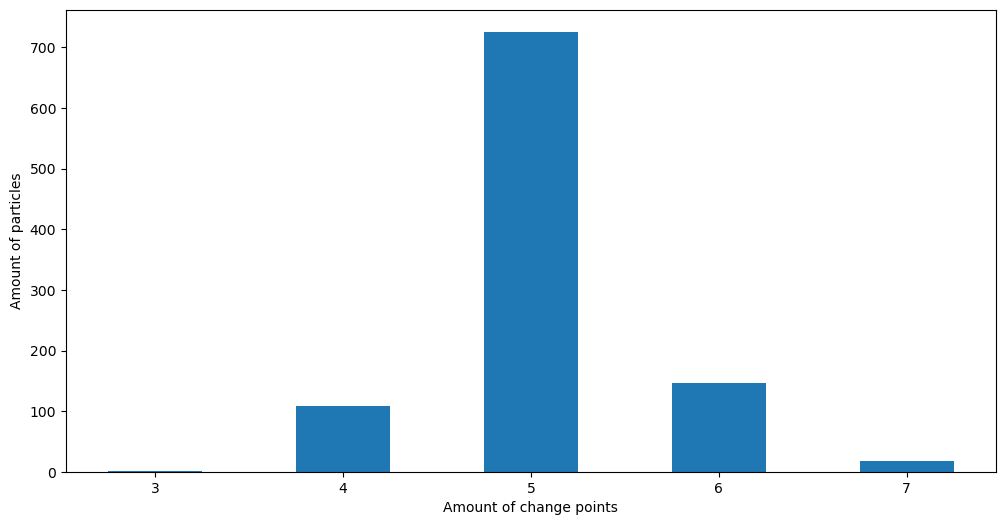

In [6]:
fig = plt.figure(figsize=(12, 6))
num_val = particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")

plt.savefig(f"{savename}/{savename}_#CP_periodic")

In [27]:
# index_ls = jnp.array([i for i, s in enumerate(data.datestr) if '-01' in s])/data.n_obs
idx = jnp.round(jnp.linspace(99, len(data.datestr) - 1, 8)).astype(int)
labels = data.datestr[idx]
indices = jnp.linspace(0, 1, 8)
print(labels)
print(indices)

['1985-04' '1989-09' '1994-01' '1998-06' '2002-10' '2007-03' '2011-07'
 '2015-12']
[0.         0.14285715 0.2857143  0.42857146 0.5714286  0.71428573
 0.8571429  1.        ]


/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


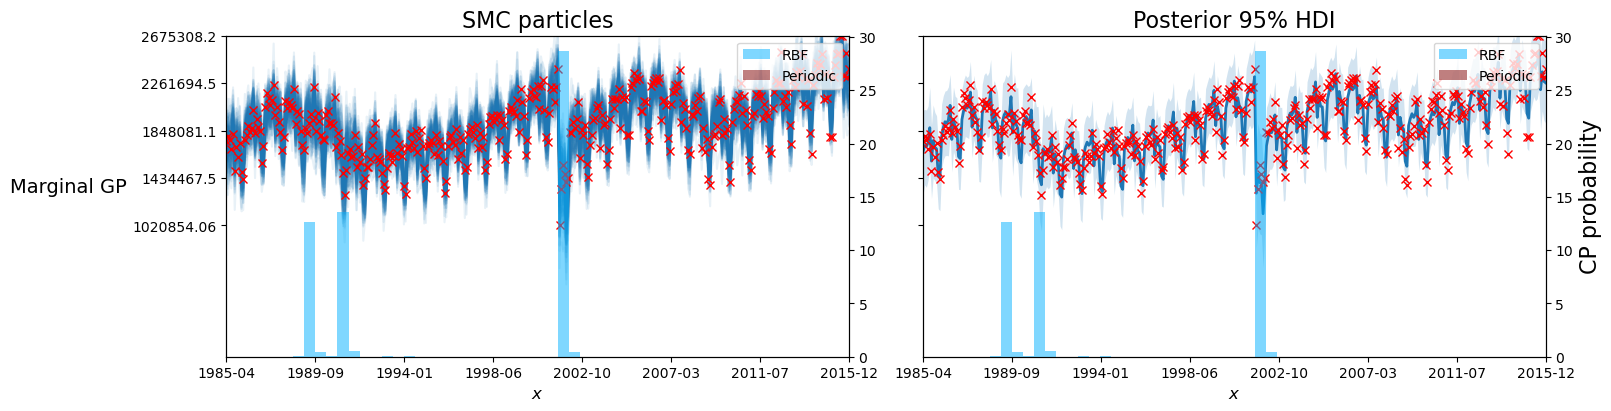

In [28]:
x_pred = jnp.linspace(-0, 1, num=len(corr_data))
x = jnp.linspace(-0,1, num=len(corr_data))
num_particles = 1000
kernels = ['RBF', 'Periodic']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)

corr_data = data.y[99:]/jnp.max(data.y[99:]).flatten()

# key, key_pred = jrnd.split(key)
# f_pred = predict_f

# print(f_pred.shape)
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

colors = plt.cm.jet(jnp.linspace(0.3,1,2))
ax2 = ax.twinx()
for i, pd in enumerate(particles['kernel']):
    new_pd = pd['num'][jnp.logical_not(jnp.isnan(pd['num']))]
    ax2.hist(new_pd, bins=30, density=True, color=colors[i], label = kernels[i], alpha=0.5)
ax2.legend()

ax = axes[1]
f_mean = jnp.nanmean(f_pred, axis=0)
# y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.nanpercentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.nanpercentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
for i, pd in enumerate(particles['kernel']):
    new_pd = pd['num'][jnp.logical_not(jnp.isnan(pd['num']))]
    ax2.hist(new_pd, bins=30, density=True, color=colors[i], alpha=0.5, label = kernels[i])
ax2.legend()
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    # ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, corr_data, 'rx', label='obs')
    ax.set_xlim([-0, 1])
    ax.set_ylim([0, 1])
    # ax.set_ylim([jnp.min(corr_data), jnp.max(corr_data)])
    ax.set_xticks(indices, labels = labels)
    ax.set_yticks(jnp.linspace(jnp.min(corr_data), jnp.max(corr_data), 5), labels = jnp.round(jnp.linspace(jnp.min(data.y), jnp.max(data.y), 5), 3))
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

plt.savefig(f"{savename}/{savename}_fit_combined")

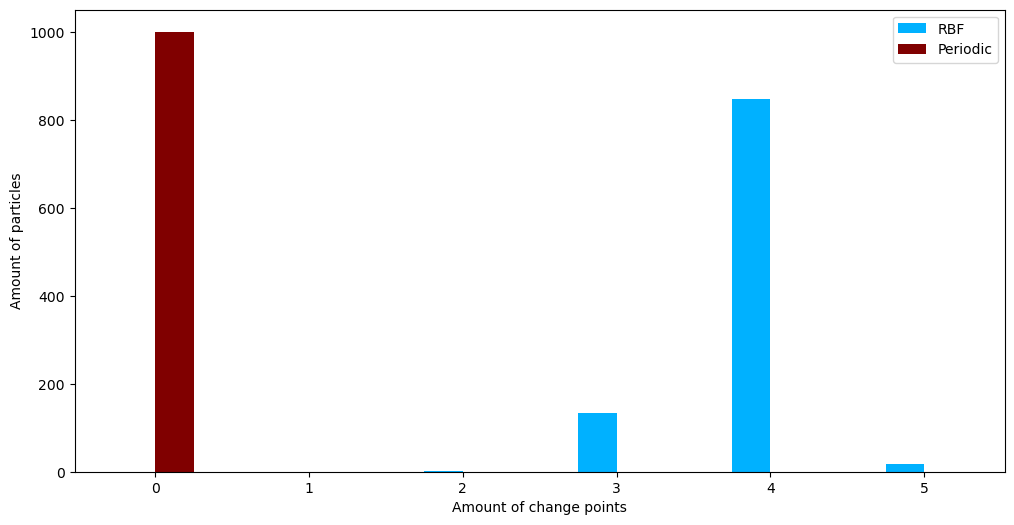

In [29]:
fig = plt.figure(figsize=(12, 6))
colors = plt.cm.jet(jnp.linspace(0.3,1,2))
labels = ['RBF', 'Periodic']
counts = jnp.zeros((1000, 2))
for i, pd in enumerate(particles['kernel']):
    num_val = pd['num']
    # print(num_val)
    counts = counts.at[:, i].set(jnp.count_nonzero(~jnp.isnan(num_val), axis = 1))
    uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts.T, bins=uni_vals, rwidth = 0.5, color=colors, label=labels)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")
plt.legend()

plt.savefig(f"{savename}/{savename}_num_combined")

plt.show()

